<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import pytorch and make data agnostic code


In [1]:
import torch
from torch import nn
#version>=1.10.0 requried for this notebook
torch.__version__

'2.2.1+cu121'

In [2]:
#device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Getting data

In [3]:
#Data of commonly used dataset Food101 will be used. It has 1000 datapoints of 101 different food items
#will take 3 food items here. starting small to build the neural network, will then increase later

In [4]:
import requests
import zipfile
from pathlib import Path

#setup path to data folder
data_path= Path("data/")
image_path=data_path/"food_stuff"
#check if image folder exists or not, if not prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Didnt find {image_path}, creating...")
  image_path.mkdir(parents=True, exist_ok=True)
  #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
  #download pizza, steak, sushi data in zip file
  with open(data_path/"food_stuff.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(request.content)
  #unzip data
  with zipfile.ZipFile(data_path/"food_stuff.zip","r") as zip_ref:
    print("Unzipping food_stuff file...")
    zip_ref.extractall(image_path)

Didnt find data/food_stuff, creating...
Unzipping food_stuff file...


Visualizing how data is given

In [5]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There's {len(dirnames)} directories and {len(filenames)} images/files in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There's 2 directories and 0 images/files in 'data/food_stuff'.
There's 3 directories and 0 images/files in 'data/food_stuff/train'.
There's 0 directories and 78 images/files in 'data/food_stuff/train/pizza'.
There's 0 directories and 72 images/files in 'data/food_stuff/train/sushi'.
There's 0 directories and 75 images/files in 'data/food_stuff/train/steak'.
There's 3 directories and 0 images/files in 'data/food_stuff/test'.
There's 0 directories and 25 images/files in 'data/food_stuff/test/pizza'.
There's 0 directories and 31 images/files in 'data/food_stuff/test/sushi'.
There's 0 directories and 19 images/files in 'data/food_stuff/test/steak'.


In [7]:
#setting up training and testing data paths
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir, test_dir

(PosixPath('data/food_stuff/train'), PosixPath('data/food_stuff/test'))

See an image


Random Image Path:data/food_stuff/train/sushi/268990.jpg
Image Class:sushi
Image Height:512
Image Width:384


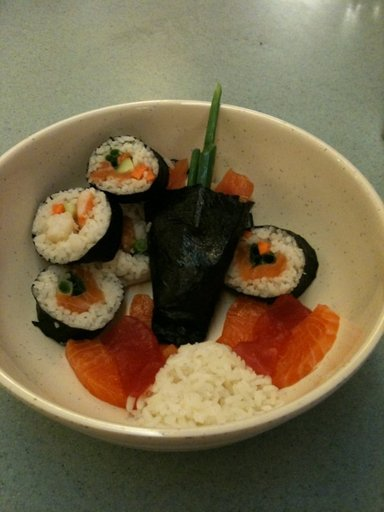

In [8]:
#Using PIL
import random
from PIL import Image
#setting seed
random.seed(59)
#getting all image paths (*= any combination)
image_path_list=list(image_path.glob("*/*/*.jpg"))
#get random image path
rand_img_path=random.choice(image_path_list)
#get image class from path name (image class name of directory where image is stored)
image_class=rand_img_path.parent.stem

#opening image
img=Image.open(rand_img_path)
#print metadata
print(f"Random Image Path:{rand_img_path}")
print(f"Image Class:{image_class}")
print(f"Image Height:{img.height}")
print(f"Image Width:{img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

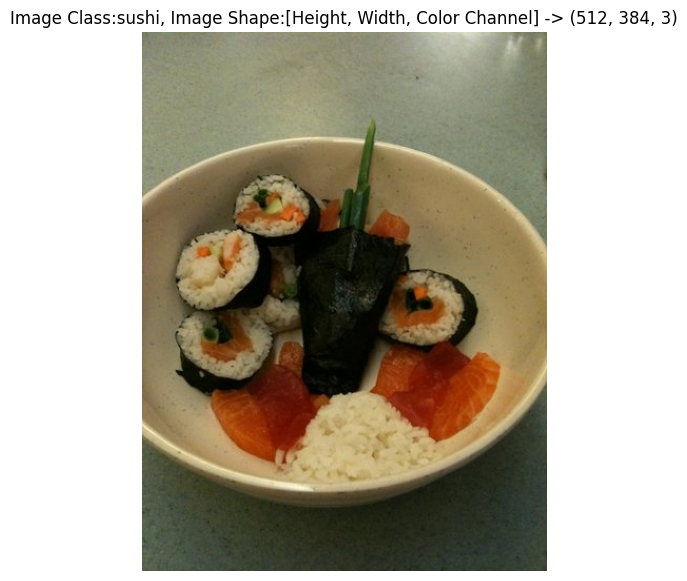

In [9]:
#Using Matplotlib.pyplot.imshow
import numpy as np
import matplotlib.pyplot as plt
#turning image to array
img_as_array=np.asarray(img)
#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class:{image_class}, Image Shape:[Height, Width, Color Channel] -> {img_as_array.shape}")
plt.axis(False)

Tranforming Data and making appropriate dataset and dataloader

In [10]:
#we will convert image into datasets and dataloaders
#following datasets and functions are used for the corresponding problems
#Vision: torchvision.datasets
#Audio: torchaudio.datasets
#Text: torchtext.datasets
#Recommendation Systems: torchrec.datasets

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#torchvision.transforms module contains functions for manipulating data according to our wishes.
#also its used for dataaugmentation: Augmenting data to make it harder for our model to learn(on purpose)

In [12]:
#Write transform for image, here we are first resizing image form (512,512) to (64,64), then randomly flipping them to their horizontal axis and then converting them into tensors
data_transform=transforms.Compose([
    #Resizing
    transforms.Resize(size=(64,64)),
    #Flipping images randomly(kind of data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),#p=Probability of flip
    #turning image into a tensor
    transforms.ToTensor()#also converts pixel value(ranging form 0 to 255) to be between 0.0 and 1.0
])

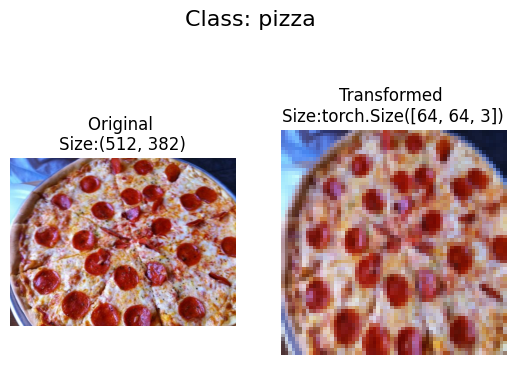

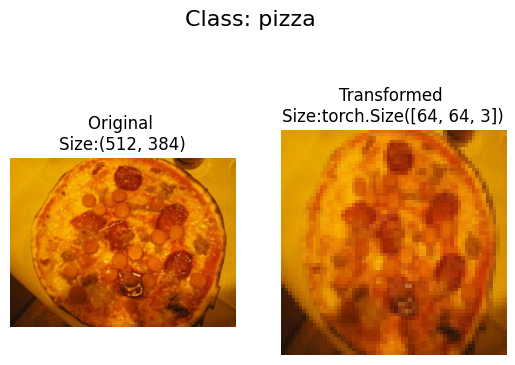

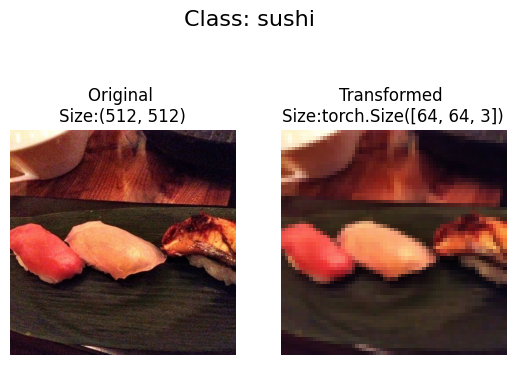

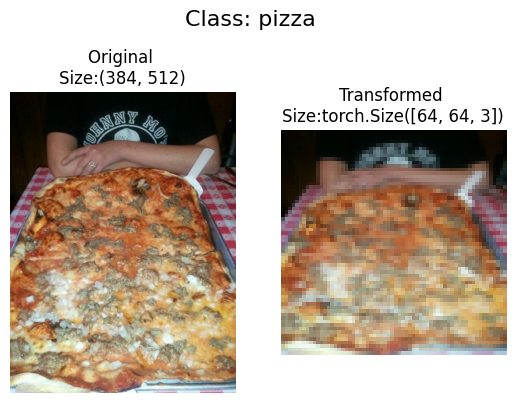

In [13]:
def plotting_transformed_image(image_paths, transform, n=3, seed=69):
  #will plot n random images from image path list
  #will plot original and trnasformed images side by side
  #Args:
  # image path(list): list of image paths
  #transform: transform to apply to images
  #number of images to plot
  #seed: random seed
  random.seed(seed)
  random_image_paths=random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize:{f.size}")
      ax[0].axis("off")

      #Transform and plot image
      #permute() will change shape to suit matplotlib
      #PyTorch default is [C,W,H] whereas Matplotlib is [H,W,C]
      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plotting_transformed_image(image_path_list,
                           transform=data_transform,
                           n=4)

Using ImageFolder to load image data

In [14]:
#using torchvision.datasets.ImageFolder for converting image to datasets
training_data=datasets.ImageFolder(root=train_dir,#directory from where to get training data
                                   transform=data_transform,#transformations to apply
                                   target_transform=None)#transforms to perform on labels(if required)
testing_data=datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
print(f"Training Data:{training_data}, Testing Data:{testing_data}")

Training Data:Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/food_stuff/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ), Testing Data:Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/food_stuff/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
#getting classes names as a list
class_names=training_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
#getting classes names as a dictionary
training_data.class_to_idx, testing_data.class_to_idx


({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [17]:
len(training_data),len(testing_data)

(225, 75)

In [18]:
training_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [19]:
print(f"Some Image in training dataset={training_data[68][0]}\nLabel of the corresponding image={training_data[68][1]}")

Some Image in training dataset=tensor([[[0.5451, 0.7529, 0.8980,  ..., 0.3412, 0.3373, 0.3451],
         [0.5412, 0.7176, 0.8902,  ..., 0.3569, 0.3294, 0.3412],
         [0.5490, 0.6902, 0.8706,  ..., 0.3686, 0.3490, 0.3294],
         ...,
         [0.3490, 0.3255, 0.3255,  ..., 0.5490, 0.6157, 0.5098],
         [0.3137, 0.3059, 0.3176,  ..., 0.4745, 0.5686, 0.6235],
         [0.3020, 0.2941, 0.3098,  ..., 0.4118, 0.5412, 0.6078]],

        [[0.3647, 0.6784, 0.8745,  ..., 0.3490, 0.3412, 0.3490],
         [0.3608, 0.6314, 0.8706,  ..., 0.3608, 0.3294, 0.3451],
         [0.3765, 0.5922, 0.8353,  ..., 0.3608, 0.3373, 0.3216],
         ...,
         [0.2980, 0.2824, 0.2941,  ..., 0.4431, 0.5176, 0.4196],
         [0.2588, 0.2627, 0.2863,  ..., 0.3843, 0.4745, 0.5137],
         [0.2510, 0.2510, 0.2745,  ..., 0.3216, 0.4549, 0.5098]],

        [[0.2588, 0.6745, 0.9137,  ..., 0.3725, 0.3608, 0.3569],
         [0.2510, 0.6235, 0.9020,  ..., 0.3843, 0.3490, 0.3569],
         [0.2510, 0.5765, 0

In [20]:
training_data[0][0].shape, training_data[0][0].dtype,type(training_data[0][1])

(torch.Size([3, 64, 64]), torch.float32, int)

Image Shape:torch.Size([3, 64, 64])->[Color, Height, Width]
Permuted Shape:torch.Size([64, 64, 3])->[Height, Width, Color


Text(0.5, 1.0, 'pizza')

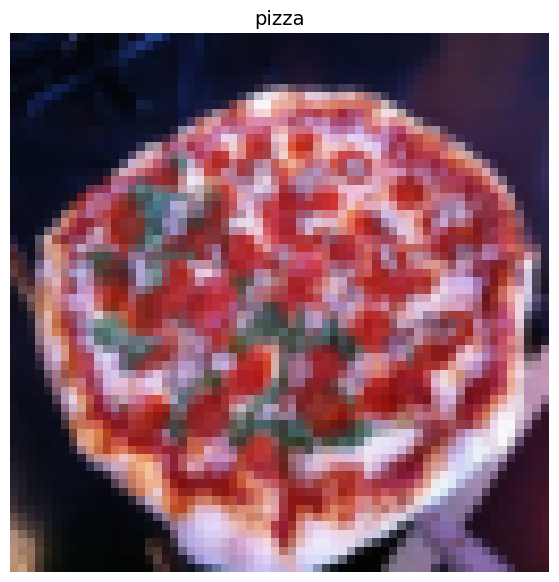

In [21]:
#will plot one image just to visualize the transformed data using matplotlib
#current data in (C,H,W) format, maplotlib prefers (H,W,C)
print(f"Image Shape:{training_data[69][0].shape}->[Color, Height, Width]")
print(f"Permuted Shape:{training_data[69][0].permute(1,2,0).shape}->[Height, Width, Color")
#plot the image
plt.figure(figsize=(10,7))
plt.imshow(training_data[69][0].permute(1,2,0))
plt.axis("off")
plt.title(class_names[training_data[69][1]], fontsize=14)

In [22]:
#above pixelation is obviously due to resizing from 512x512 to 64x64

Making dataloaders

In [23]:
os.cpu_count() #see below code block to find why did this

2

In [24]:
#while creating dataloaders a parameter called num_workers() is used which tells how much computational power pytorch uses to load your data
from torch.utils.data import DataLoader
train_dataloader=DataLoader(dataset=training_data,
                            batch_size=1,#sample per dataloader
                            num_workers=1,#as number of cpus above is 2 so keeping it less than that, can also keep 2
                            shuffle=True)#shuffling images
test_dataloader=DataLoader(dataset=testing_data,
                           batch_size=1,
                           num_workers=1,
                           shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b50e8de7b50>,
 <torch.utils.data.dataloader.DataLoader at 0x7b50e8c54b50>)

In [25]:
img,label= next(iter(train_dataloader))
print(f"Image Shape:{img.shape} -> [batch size, color, height, width]")
print(f"Label Shape:{label.shape}")

Image Shape:torch.Size([1, 3, 64, 64]) -> [batch size, color, height, width]
Label Shape:torch.Size([1])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Defining more transforms

In [26]:
from torchvision import transforms

train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #31 is the most intense
    transforms.ToTensor()#using this gets all values between 0 & 1
])
#not putting TrivialAugmentWide transform in test transforms
test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()#using this gets all values between 0 & 1
])


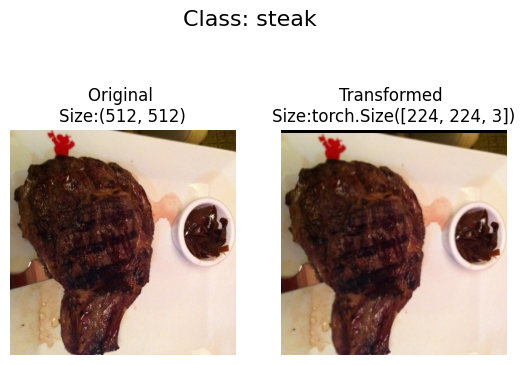

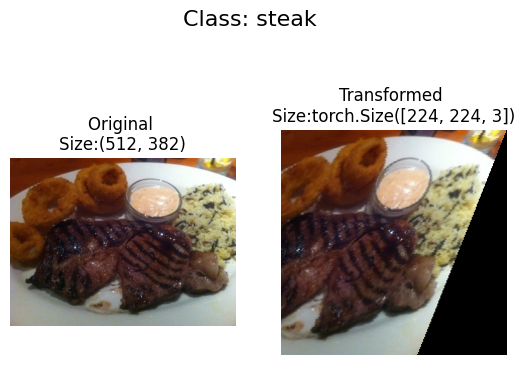

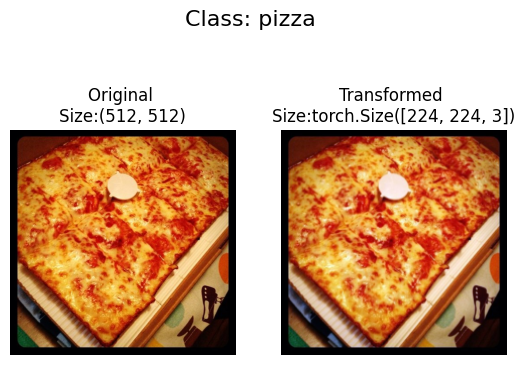

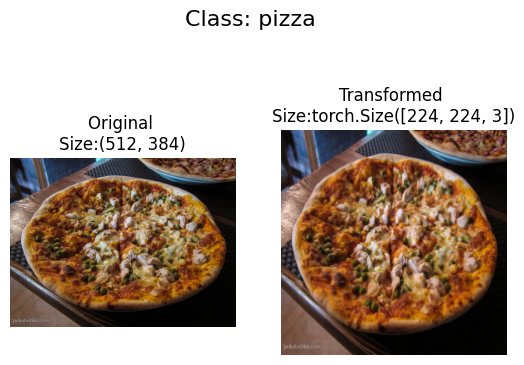

In [27]:
#testing the above data augmentation
#get all image paths
image_path_list= list(image_path.glob("*/*/*.jpg"))

#Plot random image
plotting_transformed_image(image_path_list,
                           transform=train_transforms,
                           n=4,
                           seed=None)

TinyVGG (without data augmentation)

In [28]:
#simple transform
simple_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [29]:
#Loading the data
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple= datasets.ImageFolder(root=test_dir, transform=simple_transform)

#turning into dataloader
import os
from torch.utils.data import DataLoader

#Setup batchsize no. of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
print(f'Create dataloader with batch size={BATCH_SIZE}, AND {NUM_WORKERS} workers')
#Making dataloader
simple_train_dataloader=DataLoader(train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)
simple_test_dataloader=DataLoader(train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)
simple_train_dataloader,simple_test_dataloader

Create dataloader with batch size=32, AND 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x7b50e8a4ecb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b50e8a16890>)

In [30]:
#making tinyVGG model
#here RGB images instead of grayscale so in_channels=3
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int) -> None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)#stride = kernel size by default
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  def forward(self,x:torch.Tensor):
    x=self.conv_block_1(x)
    #print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x
    #to save time, in case tensor need not be printed after each layer, can do all layers one after other and directly return the final tensor rather than how its done here by assigning values to x tensor after each layer
torch.manual_seed(69)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(training_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Testing model by passing a single image through the layers

In [31]:
#getting single batch from dataloader
img_batch,label_batch=next(iter(simple_train_dataloader))

#get single image and unsqueeze so shape fits model
single_img, single_label=img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"single imkage shape:{single_img.shape}\n")

#perform forward pass
model_0.eval()
with torch.inference_mode():
  pred=model_0(single_img.to(device))

#printing outputs and converting to pred_probs and pred_labels
print(f"output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred,dim=1)}\n")
print(f"Output prediction label:\n {torch.argmax(torch.softmax(pred, dim=1),dim=1)}\n")
print(f"Actual label:{single_label}")

single imkage shape:torch.Size([1, 3, 64, 64])

output logits:
tensor([[0.0022, 0.0336, 0.0026]])

Output prediction probabilities:
tensor([[0.3298, 0.3403, 0.3299]])

Output prediction label:
 tensor([1])

Actual label:2


In [32]:
#torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model.
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Make and functionalize training and testing loops

In [33]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc


In [47]:
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc


Making a function to combine above 2 functions train_step() and test_step()

In [49]:
from tqdm.auto import tqdm

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Recreating model 0


In [55]:
#set random seeds
torch.manual_seed(69)
torch.cuda.manual_seed(69)
#set number of epochs
num_epochs=25

#recreate instance of TinyVGG
model_0= TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(training_data.classes)).to(device)
#setting up loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001)

#start the timer
from timeit import default_timer as timer
start_time=timer()
#train model_0
model_0_results= train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=num_epochs)
# end timer and find how long it took
end_time=timer()
print(f"Total training time:{end_time-start_time: .3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1|Train Loss:1.1087|Training Accuracy: 0.3244|Test Loss: 1.1023|Test Accuracy: 0.2533
Epoch:2|Train Loss:1.1006|Training Accuracy: 0.3378|Test Loss: 1.1002|Test Accuracy: 0.2533
Epoch:3|Train Loss:1.0992|Training Accuracy: 0.3200|Test Loss: 1.0998|Test Accuracy: 0.2533
Epoch:4|Train Loss:1.0992|Training Accuracy: 0.3200|Test Loss: 1.1008|Test Accuracy: 0.2533
Epoch:5|Train Loss:1.1095|Training Accuracy: 0.3156|Test Loss: 1.1007|Test Accuracy: 0.2533
Epoch:6|Train Loss:1.0992|Training Accuracy: 0.3111|Test Loss: 1.0985|Test Accuracy: 0.4133
Epoch:7|Train Loss:1.0999|Training Accuracy: 0.2844|Test Loss: 1.1006|Test Accuracy: 0.3333
Epoch:8|Train Loss:1.0991|Training Accuracy: 0.3467|Test Loss: 1.1010|Test Accuracy: 0.3333
Epoch:9|Train Loss:1.0990|Training Accuracy: 0.3333|Test Loss: 1.1013|Test Accuracy: 0.3333
Epoch:10|Train Loss:1.0989|Training Accuracy: 0.3467|Test Loss: 1.1012|Test Accuracy: 0.3333
Epoch:11|Train Loss:1.0983|Training Accuracy: 0.3467|Test Loss: 1.1014|Test Acc

Plotting loss curve of model_0


In [56]:
#plotting values in model_0 dictionary
#checking keys in model_0 dictionary
model_0_results.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc'])

In [57]:
#define function to take the values in th e dictionary and plot
def plot_loss_curves(results):
  train_loss=results['train_loss']
  test_loss=results['test_loss']
  train_accuracy=results['train_acc']
  test_accuracy= results['test_acc']
  epochs=range(len(results['train_loss']))
  plt.figure(figsize=(16,8))

  #plotting loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train loss')
  plt.plot(epochs,test_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()
  #plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label='train accuracy')
  plt.plot(epochs,test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

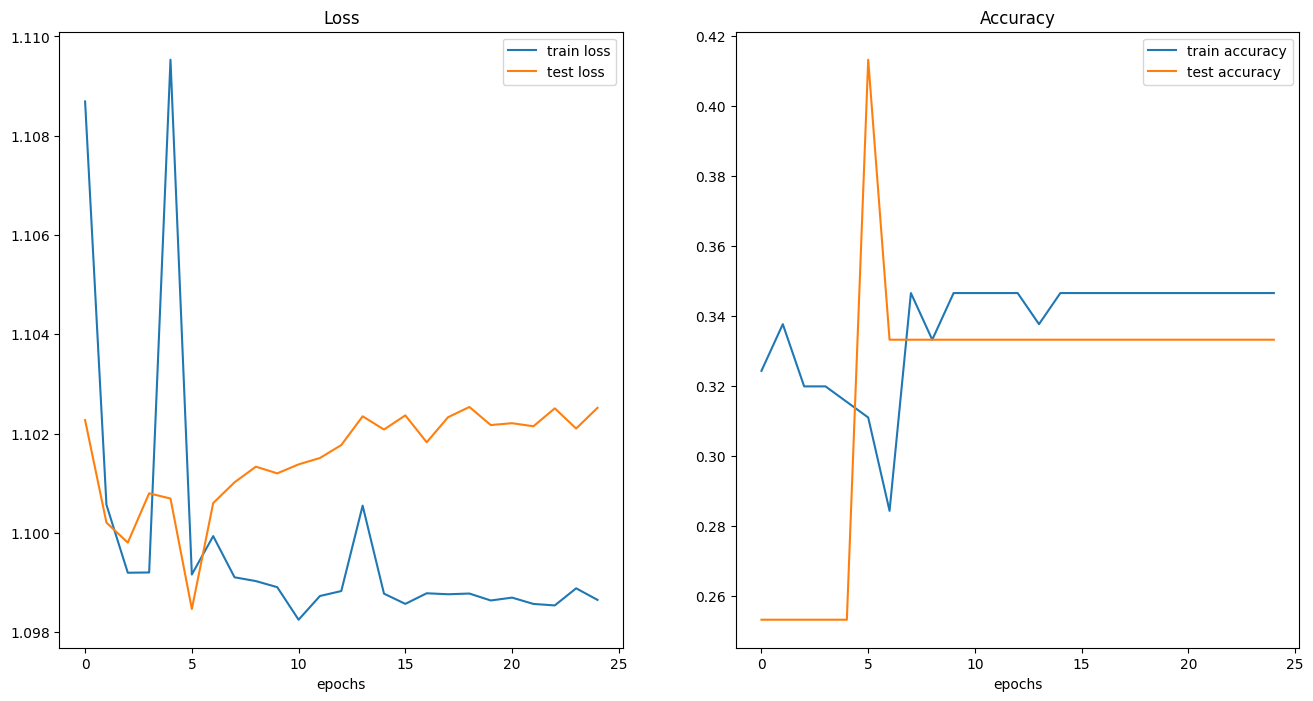

In [58]:
plot_loss_curves(model_0_results)

Can obviously see above, loss is not going down to 0  and accuracy gets limited at a low value so need a different model as this model isnt obviously learning anything

Now we will try TinyVGG model with data augmentation

In [64]:
#create training transform using TrivialAugment
train_transform_trivial_augment=transforms.Compose([transforms.Resize((64,64)),
                                                    transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                    transforms.ToTensor()])
#create testing transform (no data augmentation)
test_transform=transforms.Compose([transforms.Resize((64,64)),
                                    transforms.ToTensor()])

In [68]:
#again using ImageFolder as before to convert images into data, this time only using different transformation
augmented_training_data=datasets.ImageFolder(root=train_dir,#directory from where to get training data
                                   transform=train_transform_trivial_augment,#transformations to apply
                                   target_transform=None)#transforms to perform on labels(if required)
simple_testing_data=datasets.ImageFolder(root=test_dir,#directory from where to get training data
                                   transform=test_transform,#transformations to apply
                                   target_transform=None)

In [69]:
augmented_training_data, simple_testing_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food_stuff/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food_stuff/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food_stuff/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food_stuff/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [71]:
#converting into dataloaders
import os
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(38)
train_dataloader_augmented= DataLoader(augmented_training_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)
test_dataloader_simple= DataLoader(simple_testing_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)
train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7b50d3996740>,
 <torch.utils.data.dataloader.DataLoader at 0x7b50d39960b0>)

In [73]:
#create model_1 using TinyVGG class and send to device
torch.manual_seed(39)
model_1= TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(augmented_training_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

time to train

In [76]:
#set random seeds
torch.manual_seed(69)
torch.cuda.manual_seed(69)
#set number of epochs
num_epochs=25

#setting up loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001)

#start the timer
from timeit import default_timer as timer
start_time=timer()
#train model_0
model_1_results= train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=num_epochs)
# end timer and find how long it took
end_time=timer()
print(f"Total training time:{end_time-start_time: .3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1|Train Loss:1.0970|Training Accuracy: 0.4023|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:2|Train Loss:1.0970|Training Accuracy: 0.4023|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:3|Train Loss:1.0986|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:4|Train Loss:1.0986|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:5|Train Loss:1.1021|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:6|Train Loss:1.0988|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:7|Train Loss:1.0969|Training Accuracy: 0.4023|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:8|Train Loss:1.1020|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:9|Train Loss:1.1019|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:10|Train Loss:1.0989|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Accuracy: 0.5417
Epoch:11|Train Loss:1.1018|Training Accuracy: 0.2812|Test Loss: 1.0942|Test Acc

plotting loss curves

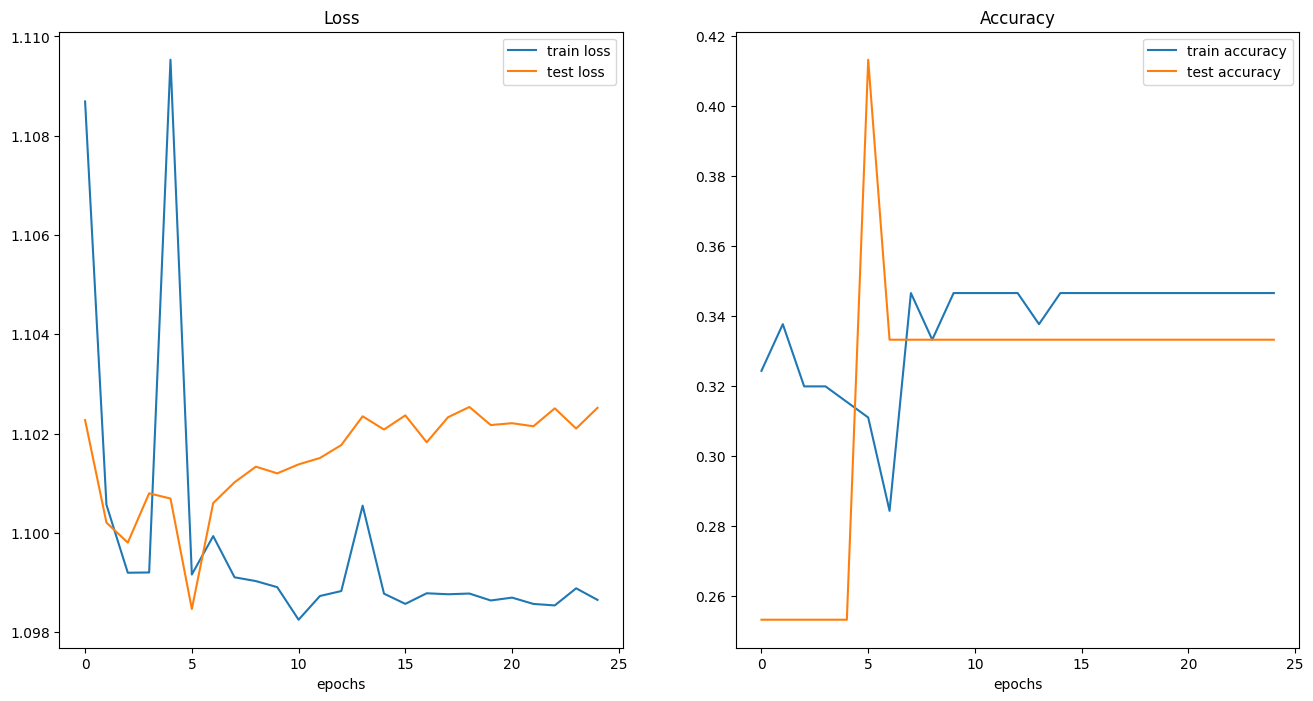

In [77]:
plot_loss_curves(model_0_results)

above loss curves still dont look good, need lower loss and higher accuracy